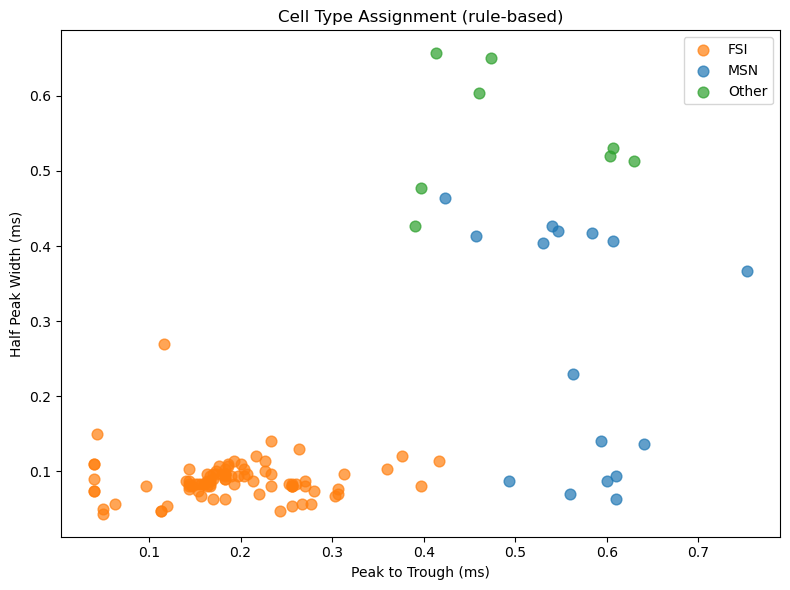

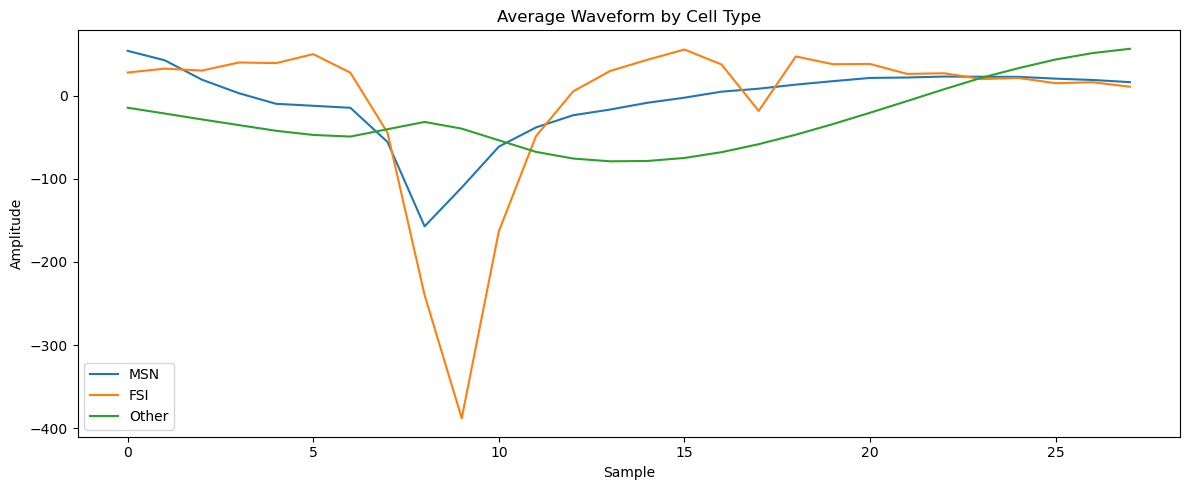

Saved results and plots in Z:\Koji\Neuropixels\1818\1818_11202025_g0\1818_11202025_g0_imec0\kilosort4


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Replace with your root data folder
day_folders = [
    r"Z:\Koji\Neuropixels\1818\1818_11202025_g0\1818_11202025_g0_imec0\kilosort4"
]

for folder in day_folders:
    metrics_path = os.path.join(folder, "template_metrics.csv")
    waveform_path = os.path.join(folder, "waveform_beh_average.npy")
    out_csv = os.path.join(folder, "unit_classification_rulebased.csv")

    # --- Load data ---
    metrics = pd.read_csv(metrics_path)
    metrics['unit_id'] = metrics['Unnamed: 0'].astype(int)
    wf_dict = np.load(waveform_path, allow_pickle=True).item()

    # --- Apply cutoffs ---
    def classify(row):
        ptv = row['peak_to_valley']*1000
        hfw = row['half_width']*1000
        if ptv < 0.42 and hfw < 0.4:
            return "FSI"
        elif ptv >= 0.42 and hfw < 0.5:
            return "MSN"
        else:
            return "Other"
    metrics['cell_type'] = metrics.apply(classify, axis=1)

    # --- Plot 2D scatter ---
    colors = {'FSI':'C1', 'MSN':'C0', 'Other':'C2'}
    plt.figure(figsize=(8,6))
    for ct in ['FSI', 'MSN', 'Other']:
        idx = metrics['cell_type'] == ct
        plt.scatter(metrics.loc[idx, 'peak_to_valley']*1000, metrics.loc[idx, 'half_width']*1000,
                    c=colors[ct], label=ct, s=60, alpha=0.7)
    plt.xlabel('Peak to Trough (ms)')
    plt.ylabel('Half Peak Width (ms)')
    plt.title('Cell Type Assignment (rule-based)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(folder, "rulebased_celltype_scatter.png"))
    plt.show()

    # --- Plot mean waveform for each group ---
    plt.figure(figsize=(12,5))
    for ct in ['MSN', 'FSI', 'Other']:
        unit_ids = metrics.loc[metrics['cell_type'] == ct, 'unit_id']
        # Filter out None waveforms
        waveforms = [wf_dict[uid] for uid in unit_ids if uid in wf_dict and wf_dict[uid] is not None]
        if not waveforms:
            continue
        mean_wf = np.mean(waveforms, axis=0)
        plt.plot(mean_wf, label=ct)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Average Waveform by Cell Type')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(folder, "rulebased_celltype_waveforms.png"))
    plt.show()

    # --- Save results ---
    metrics[['unit_id', 'peak_to_valley', 'half_width', 'cell_type']].to_csv(out_csv, index=False)
    print(f"Saved results and plots in {folder}")